MNIST GAN
---------

In this example, we will train a Generative Adversarial Network (GAN) on the MNIST dataset.  This is a large collection of 28x28 pixel images of handwritten digits.  We will try to train a network to produce new images of handwritten digits.

To begin, let's import all the libraries we'll need and load the dataset (which comes bundled with Tensorflow).

In [1]:
import deepchem as dc
import tensorflow as tf
from deepchem.models.tensorgraph import layers
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plot
import matplotlib.gridspec as gridspec
%matplotlib inline

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
images = mnist.train.images.reshape((-1, 28, 28, 1))
dataset = dc.data.NumpyDataset(images)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Let's view some of the images to get an idea of what they look like.

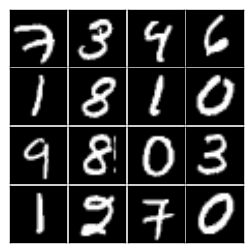

In [2]:
def plot_digits(im):
  plot.figure(figsize=(3, 3))
  grid = gridspec.GridSpec(4, 4, wspace=0.05, hspace=0.05)
  for i, g in enumerate(grid):
    ax = plot.subplot(g)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(im[i,:,:,0], cmap='gray')

plot_digits(images)

Now we can create our GAN.  It consists of two parts:

1. The generator takes random noise as its input and produces output that will hopefully resemble the training data.
2. The discriminator takes a set of samples as input (possibly training data, possibly created by the generator), and tries to determine which are which.  Its output is interpreted as the probability that each sample is from the training set.

In [3]:
class DigitGAN(dc.models.GAN):

  def get_noise_input_shape(self):
    return (None, 10)

  def get_data_input_shapes(self):
    return [(None, 28, 28, 1)]

  def create_generator(self, noise_input, conditional_inputs):
    dense1 = layers.Dense(50, in_layers=noise_input, activation_fn=tf.nn.relu, normalizer_fn=tf.layers.batch_normalization)
    dense2 = layers.Dense(28*28, in_layers=dense1, activation_fn=tf.sigmoid, normalizer_fn=tf.layers.batch_normalization)
    reshaped = layers.Reshape((None, 28, 28, 1), in_layers=dense2)
    return [reshaped]

  def create_discriminator(self, data_inputs, conditional_inputs):
    conv = layers.Conv2D(num_outputs=32, kernel_size=5, stride=2, activation_fn=dc.nn.model_ops.lrelu(0.2), normalizer_fn=tf.layers.batch_normalization, in_layers=data_inputs)
    dense = layers.Dense(1, in_layers=layers.Flatten(conv), activation_fn=tf.sigmoid)
    return dense

gan = DigitGAN(learning_rate=0.0005)

Now to train it.  The generator and discriminator are both trained together.  The generator tries to get better at fooling the discriminator, while the discriminator tries to get better at distinguishing real data from generated data (which in turn gives the generator a better training signal to learn from).

In [4]:
def iterbatches(epochs):
  for i in range(epochs):
    for batch in dataset.iterbatches(batch_size=gan.batch_size):
      yield {gan.data_inputs[0]: batch[0]}

gan.fit_gan(iterbatches(50), generator_steps=1.5, checkpoint_interval=5000)

Ending global_step 5000: generator average loss 5.6996, discriminator average loss 0.0341601
Ending global_step 10000: generator average loss 4.60495, discriminator average loss 0.112247
Ending global_step 15000: generator average loss 3.5461, discriminator average loss 0.205332
Ending global_step 20000: generator average loss 3.22442, discriminator average loss 0.239572
Ending global_step 25000: generator average loss 2.99321, discriminator average loss 0.292008
Ending global_step 27500: generator average loss 2.83743, discriminator average loss 0.310524
TIMING: model fitting took 291.696 s


Let's generate some data and see how the results look.

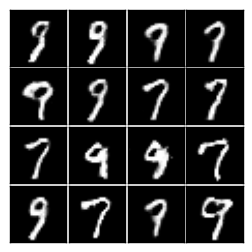

In [5]:
plot_digits(gan.predict_gan_generator(batch_size=16))

Not too bad.  Most of the generated images look convincingly like handwritten digits, but only a few digits are represented.  This is a common problem in GANs called "mode collapse".  The generator learns to produce output that closely resembles training data, but the range of its output only covers a subset of the training distribution.  Finding ways to prevent mode collapse is an active area of research for GANs.